action [0.9997831583023071, -0.9973971247673035, -0.9866398572921753, 0.9084830284118652, 0.9999997019767761, -0.9999979138374329]
action [0.9998043775558472, -0.999655544757843, -0.9752333164215088, 0.8921990990638733, 0.9999996423721313, -0.9999982118606567]
action [0.999687671661377, -0.9995750188827515, -0.9495290517807007, 0.8727608919143677, 0.9999995827674866, -0.9999983310699463]
action [0.9994757175445557, -0.9994404315948486, -0.8902140855789185, 0.8497323393821716, 0.9999995231628418, -0.9999983906745911]
action [0.9990755915641785, -0.9992148280143738, -0.7516100406646729, 0.8225198984146118, 0.999999463558197, -0.9999983906745911]
action [0.9982881546020508, -0.9988188147544861, -0.444367915391922, 0.7911111116409302, 0.9999992847442627, -0.9999982714653015]
action [0.9966734647750854, -0.9981018304824829, 0.048300959169864655, 0.7566659450531006, 0.9999990463256836, -0.9999980926513672]
action [0.9931467771530151, -0.9967441558837891, 0.5024083852767944, 0.717875480651855

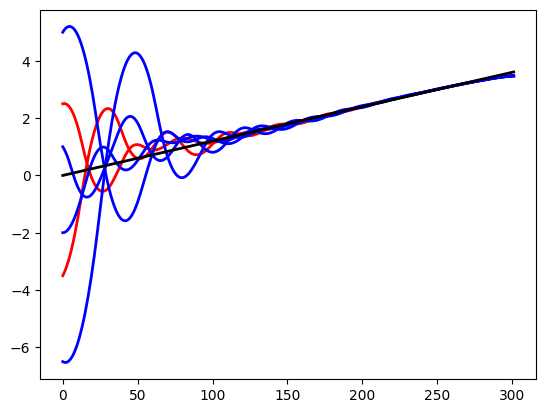

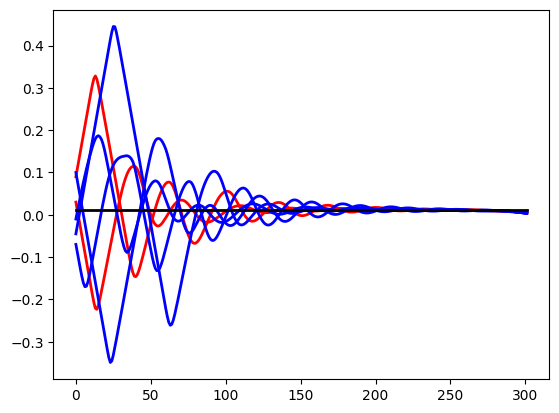

In [1]:
from myEnv import MultiAgentEnv
import torch
import torch.nn.functional as F
import numpy as np


class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = torch.tanh(self.fc_mu(x))
        std = F.softplus(self.fc_std(x)) + 0.001
        return mu, std


class PPOContinuous:
    ''' 处理连续动作的PPO算法 '''

    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim,
                                         action_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

    def take_action(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        mu, sigma = self.actor(state)
        action = mu
        action = action.tolist()[0]
        return action


actor_lr = 1e-5
critic_lr = 1e-4
num_episodes = 100
hidden_dim = 128
gamma = 0.95
lmbda = 0.9
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'myEnv'
env = MultiAgentEnv()
torch.manual_seed(0)
state_dim = 4
action_dim = 1  # 连续动作空间

agent = PPOContinuous(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device)

state = env.reset()
# 加载模型
agent.actor.load_state_dict(torch.load('MAPPO/actor.pth'))

# 循环，直到环境结束
done = False
while not done:
    actions = []
    actions_list = []
    for i in range(env.n_agents - 1):
        action = agent.take_action(state[i])
        actions.append(action)
        action = action[0]
        actions_list.append(action)

    print("action", actions_list)
    state, reward, done, error, _ = env.step(actions)  # 执行动作

env.render()  # 显示环境

env.close()